## EDA of the NASA Turbofan dataset

In [1]:
import numpy as np
import sklearn
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics.tsaplots
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

plt.rcParams['figure.dpi'] = 90
#plt.rcParams['']
np.random.seed(1337)
pd.set_option("display.max_rows",1000)
pd.options.display.float_format = '{:.4f}'.format

##### Preparing the input data to be in a suitable DataFrame, mark feature columns and set reasonable print options

In [2]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_{:d}_reading'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols
np.set_printoptions(suppress=True, threshold=10000)

train_orig = pd.read_csv('../../keras-wtte-rnn/train.csv', header=None, names=column_names)
test_x_orig = pd.read_csv('../../keras-wtte-rnn/test_x.csv', header=None, names=column_names)
test_y_orig = pd.read_csv('../../keras-wtte-rnn/test_y.csv', header=None, names=['T'])

# This will later be used in the feature generation. Background is that for the test set, we want to map the remaining TTF
# according to the info given by the "test_y.csv", while retaining the TTF per cycle similar to how it would be in the
# training dataset.
test_y_orig.index += 1

In [3]:
# Automatically inferring TTF: We take, per individual unit, the timestep and rank it (essentially inverting the timestep count), creating a unit-time-dual-index
train_orig['TTF'] = train_orig.groupby("unit_number")["time"].rank(method="min", ascending=False)
train_orig.set_index(['unit_number', 'time'], verify_integrity=True, inplace=True)

In [4]:
# For the test data, we have also to consider that the time series do not really end with failure, but with T timesteps from failure as defined in the test_y data
# Therefore we have to update the TTF labels accordingly, but first we generate the TTF in the same way as for the training set
test_x_orig['TTF'] = test_x_orig.groupby("unit_number")["time"].rank(method="min", ascending=False)
# One can now consider all these times being T-1 cycles too close to failure when considered by this method, so that's the amount of cycles that has to be added to each point
mapper = test_y_orig["T"] - 1
# Map that cycle deficiency onto the unit numbers
mapped_value = test_x_orig["unit_number"].map(mapper)
# Increment each TTF value by that mapped value, then also create a unit-time-dual-index
test_x_orig['TTF'] = test_x_orig['TTF'] + mapped_value
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True, inplace=True)

In [5]:
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# Combine the X values to normalize them later on
all_data_orig = pd.concat([train_orig, test_x_orig])
# print(all_data_orig.columns, all_data_orig.index)
all_data = all_data_orig.copy()
# all_data[feature_cols] = normalize(all_data[feature_cols].values)

def preprocess(df, feature_cols, scaler=None):
    '''Preprocessing function that either applies a passed scaler on certain columns of a DataFrame, or applies a standardscaler on them
    Also removes constant columns'''
    try:
        df.loc[:, feature_cols] = scaler.transform(df[feature_cols])
    except AttributeError:
        try:
            df.loc[:, feature_cols] = StandardScaler().fit_transform(df[feature_cols])
        except Exception as e:
            print("Either the DataFrame or the iterable of feature columns (args 1 and 2, respectively) expected are most likely faulty.\
            Please make sure these are passed properly. Error is: ", e)
            raise
    
    selector = VarianceThreshold() #Defaults to 0.0, e.g. only remove features with the same value in all samples
    #Fit the Model and obtain remaining columns
    selector.fit(df[feature_cols])
    features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
    features = [column for column in df[feature_cols].columns[features]] #Array of all nonremoved features' names

    #Format and Return
    selector = pd.DataFrame(selector.transform(df[feature_cols]))
    selector.columns = features
    selector.index = df.index
    return features, selector
new_features, all_data = preprocess(all_data, feature_cols)

D:\anaconda3\envs\stats\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\anaconda3\envs\stats\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\anaconda3\envs\stats\lib\site-packages\ipykernel\zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


In [6]:
remaining_cols = [col for col in train_orig.columns.tolist() if col in new_features] + ["TTF"]
all_data_orig.loc[:, new_features] = all_data
all_data_orig = all_data_orig[remaining_cols]

D:\anaconda3\envs\stats\lib\site-packages\ipykernel\ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


In [7]:
# Make engine numbers and days zero-indexed, then split them back into train and test data
all_data_orig.index.set_levels((all_data_orig.index.levels[0]-1, all_data_orig.index.levels[1]-1), (0,1), inplace=True)
train_ = all_data_orig.iloc[0:train_orig.shape[0], :].sort_index()
test_ = all_data_orig.iloc[train_orig.shape[0]:, :].sort_index()

#train.loc[:, 0:2] -= 1
#test.loc[:, 0:2] -= 1


In [8]:
# Get the number of the unit which has the longest observed duration
unit_tmax = train_.sort_index(level=1, ascending=False).index.get_level_values(0)[0]
# Maximum correlations of a
all_corr = all_data_orig[new_features].corr()[all_data_orig[new_features].corr() != 1].max()
train_.loc[unit_tmax, 'sensor_9_reading']

time
0     -0.4426
1     -0.2644
2     -0.5174
3     -0.0368
4      0.1086
5     -0.4531
6      0.0038
7     -0.0821
8     -0.3071
9      0.0443
10    -0.2998
11    -0.1201
12    -0.3066
13    -0.3498
14    -0.4094
15     0.2693
16    -0.4837
17     0.0217
18     0.0543
19    -0.2239
20    -0.0347
21    -0.1554
22    -0.0953
23    -0.1417
24     0.2504
25    -0.6338
26    -0.4563
27    -0.5606
28    -0.0263
29    -0.0874
30    -0.1064
31    -0.1954
32    -0.1338
33    -0.5190
34     0.0896
35    -0.2982
36    -0.2660
37    -0.2497
38     0.4401
39     0.0132
40    -0.4246
41    -0.1554
42     0.2256
43    -0.0210
44     0.2609
45    -0.3092
46    -0.5158
47    -0.0231
48    -0.4742
49    -0.5074
50    -0.2845
51    -0.1006
52    -0.3630
53    -0.1865
54     0.0891
55    -0.5822
56     0.0564
57    -0.0447
58    -0.3303
59    -0.0142
60    -0.1217
61     0.1624
62    -0.2961
63     0.1813
64    -0.1691
65    -0.0748
66    -0.1195
67    -0.1886
68    -0.5363
69    -0.0958
70    -0.3419
7

In [9]:
all_corr

op_setting_1        0.0092
op_setting_2        0.0048
sensor_2_reading    0.7087
sensor_3_reading    0.6593
sensor_4_reading    0.8058
sensor_6_reading    0.1589
sensor_7_reading    0.7896
sensor_8_reading    0.8022
sensor_9_reading    0.9513
sensor_11_reading   0.8058
sensor_12_reading   0.7896
sensor_13_reading   0.8022
sensor_14_reading   0.9513
sensor_15_reading   0.7544
sensor_17_reading   0.6897
sensor_20_reading   0.7227
sensor_21_reading   0.7263
dtype: float64

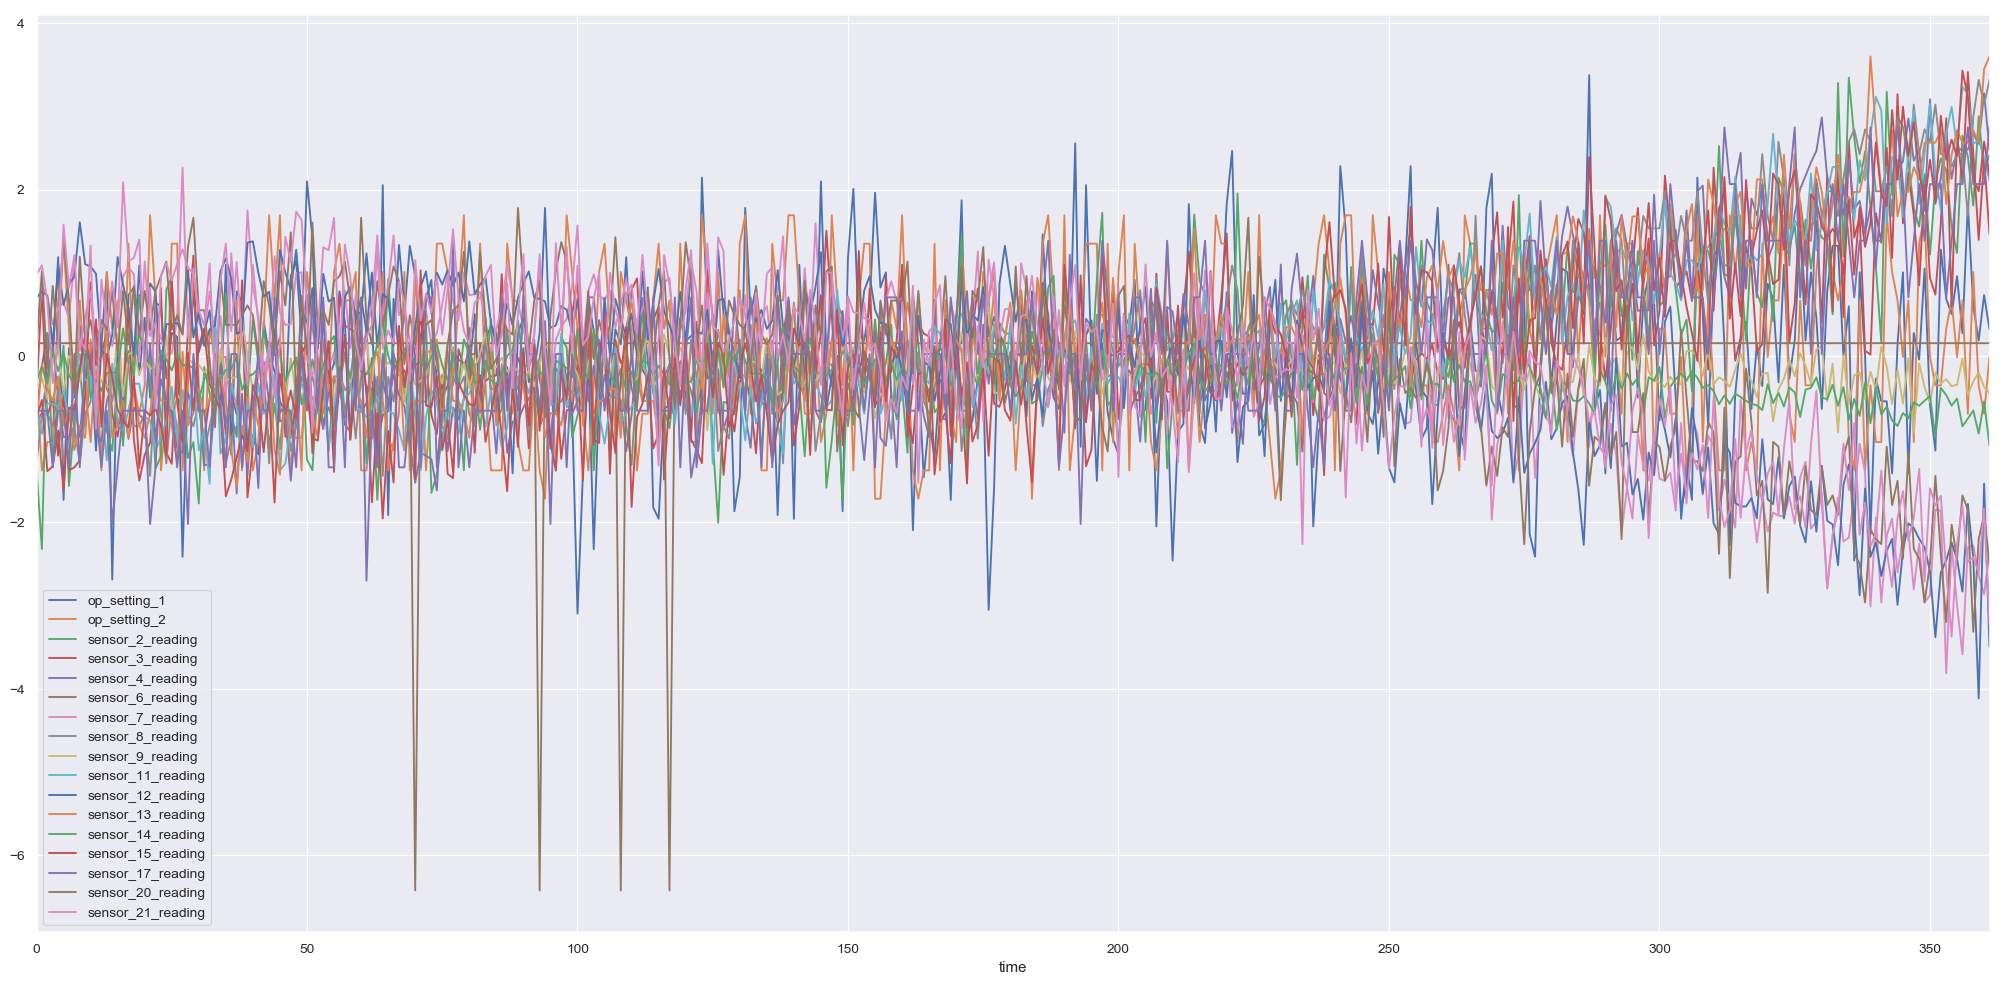

In [10]:
to_dct = (train_.loc[unit_tmax, new_features])
train_.loc[unit_tmax, new_features].plot(figsize=(28,13.5))

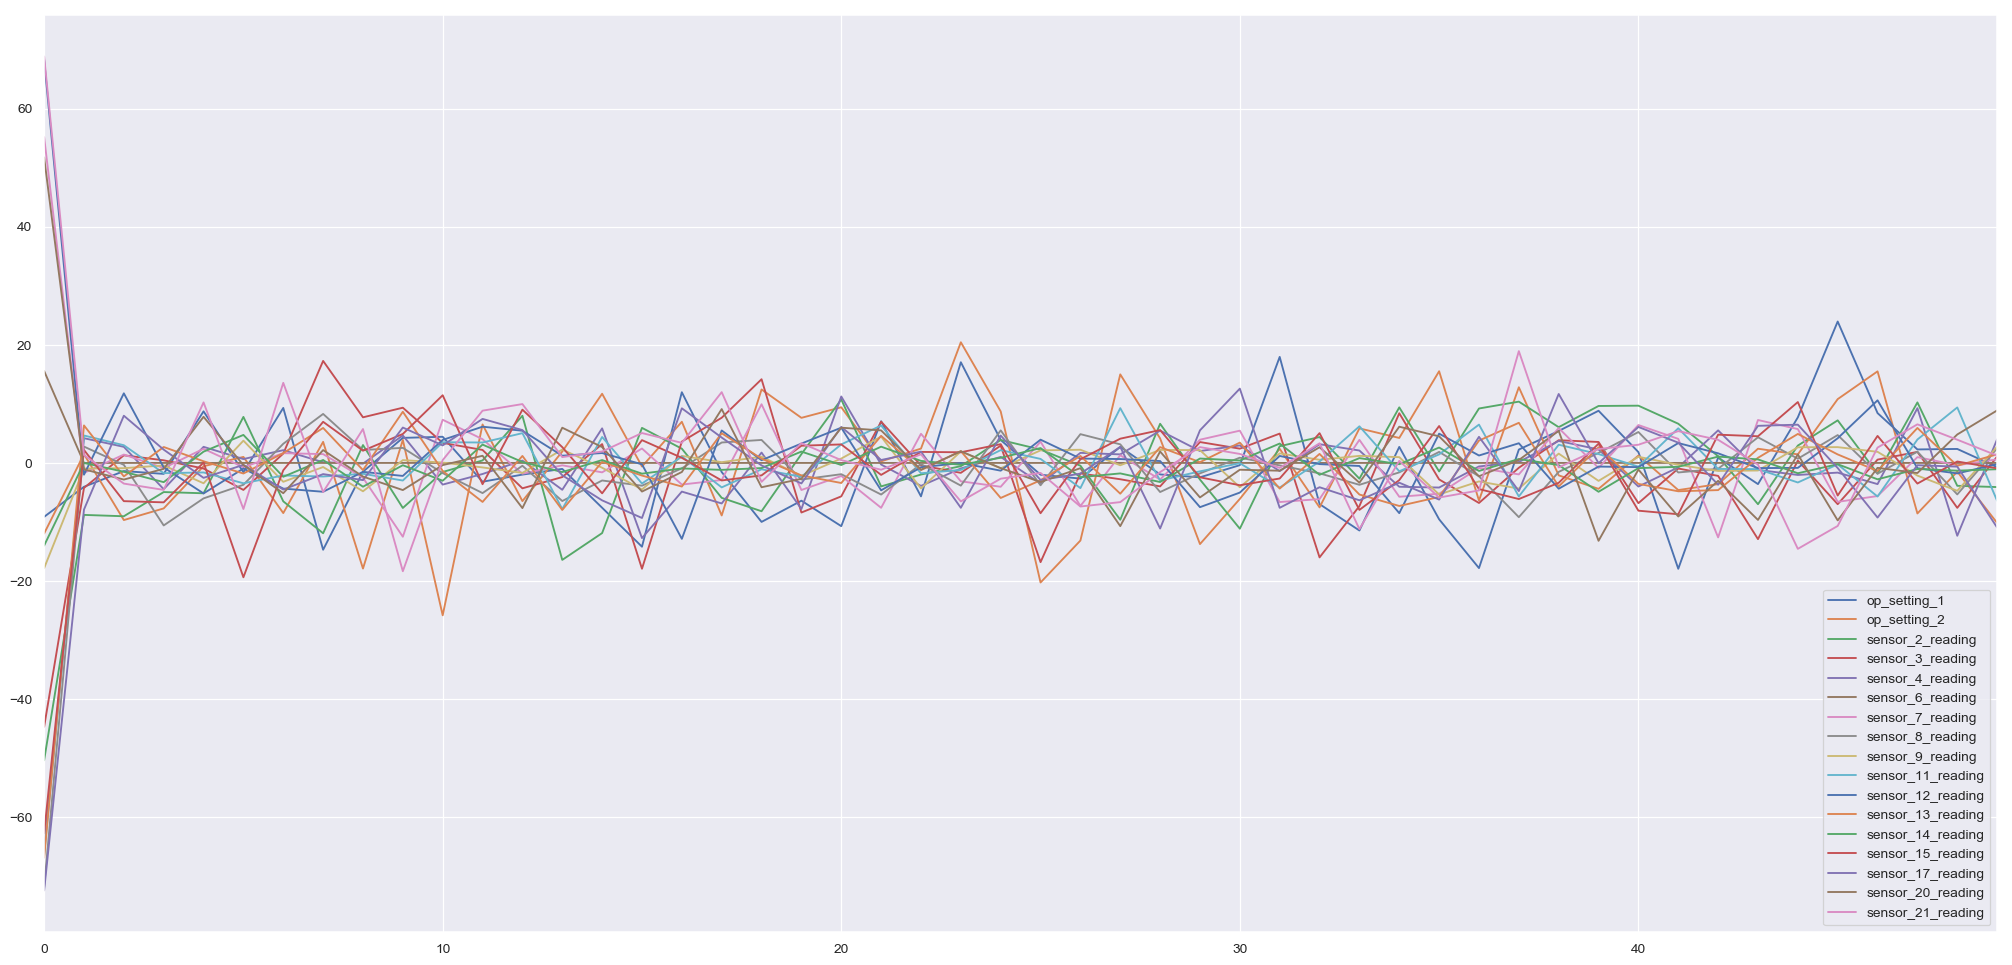

In [11]:
#to_dct.values = scipy
dct = pd.DataFrame(scipy.fftpack.dct(to_dct, axis=0, n=50), columns=to_dct.columns)
dct.plot(figsize=(28,13.5))

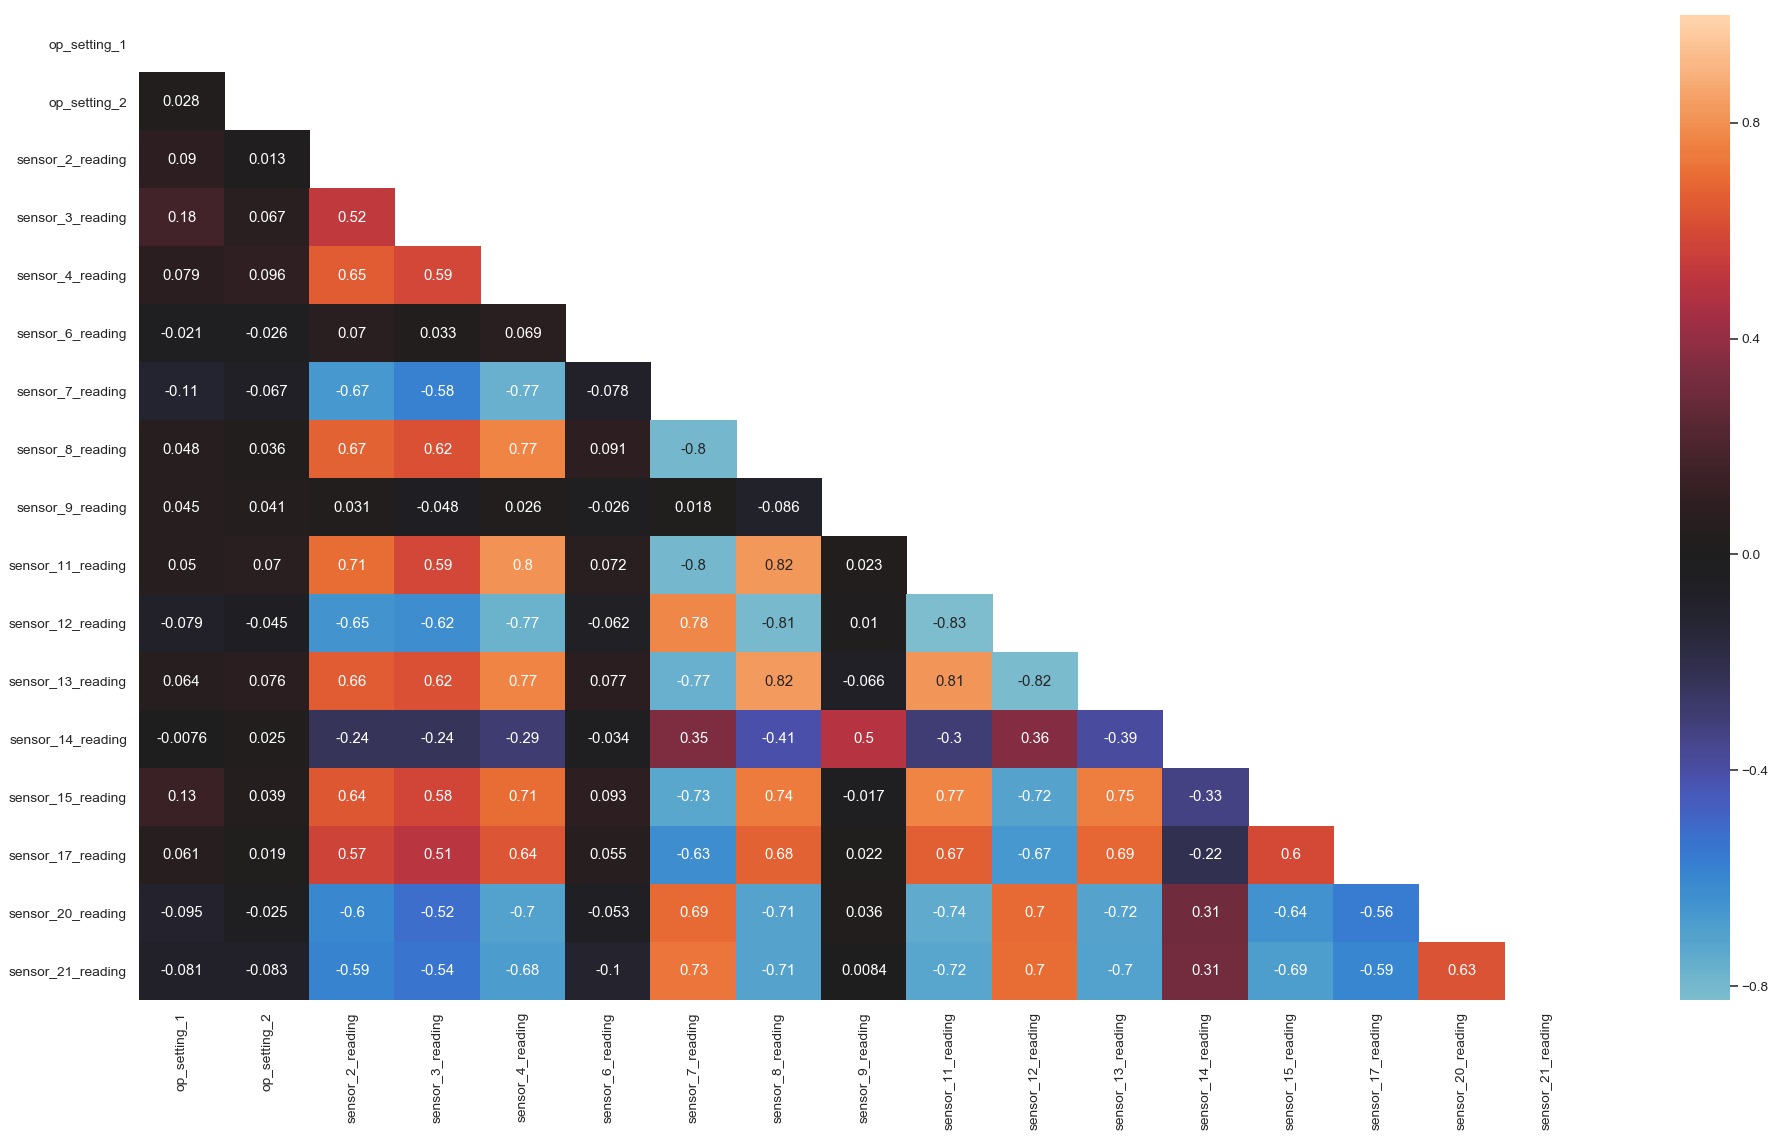

In [12]:
corr_sample = all_data_orig.loc[unit_tmax, new_features].corr()
mask = np.zeros_like(corr_sample)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(26,14.5))
    ax = sns.heatmap(corr_sample, mask=mask, ax=ax, annot=True, center=0)

In [13]:
#grid = sns.pairplot(corrs_1, kind='reg', mask=mask, height=4, aspect=1)
#grid.savefig('../images/corr.svg')

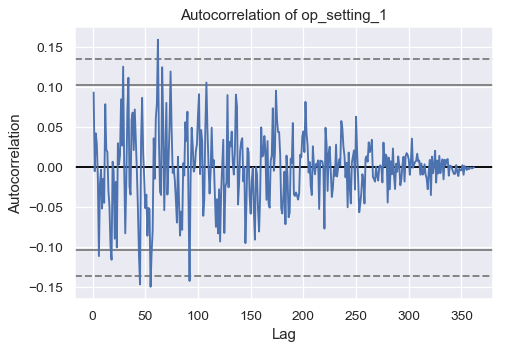

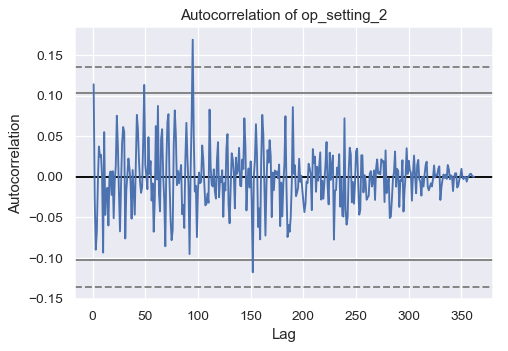

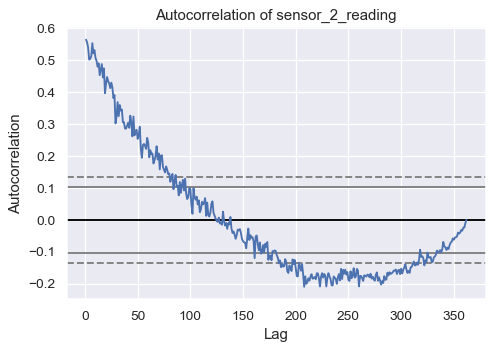

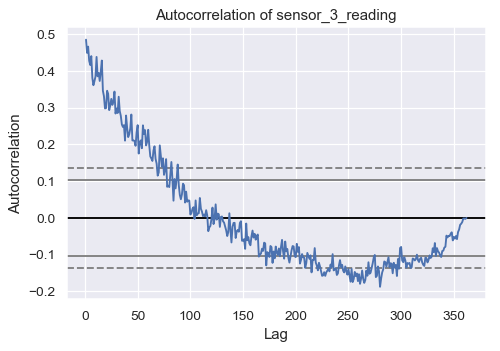

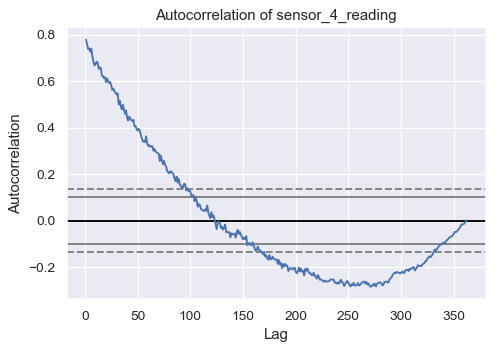

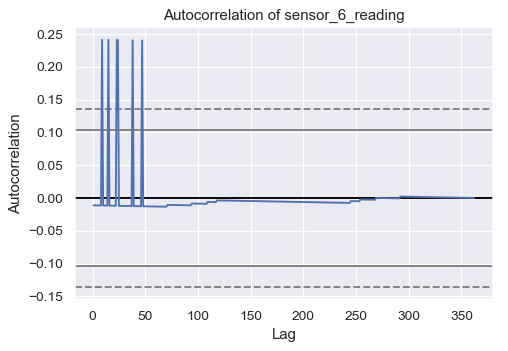

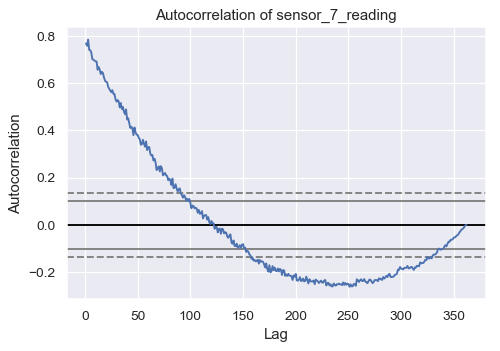

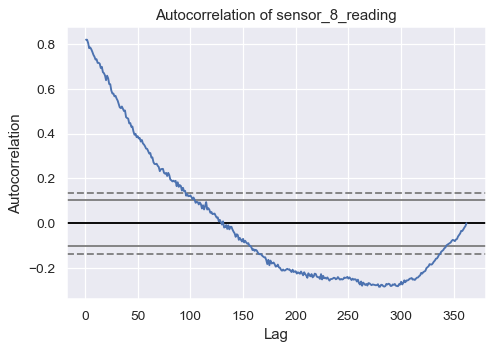

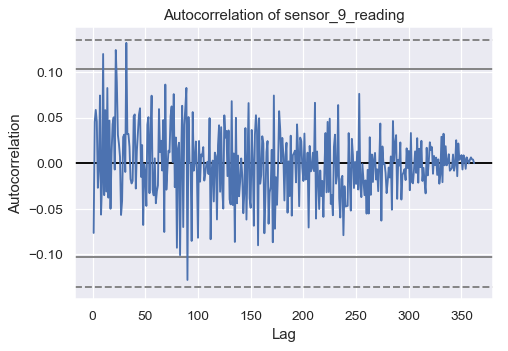

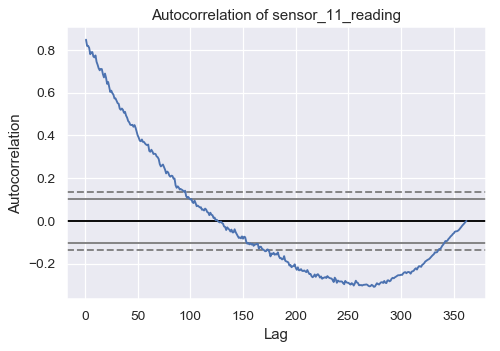

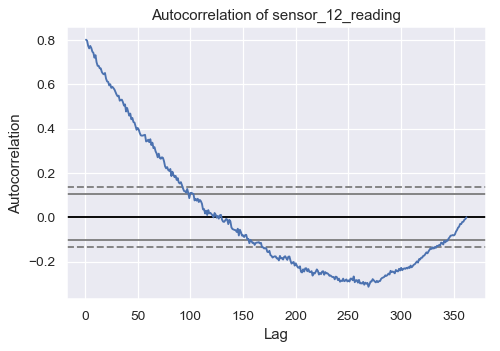

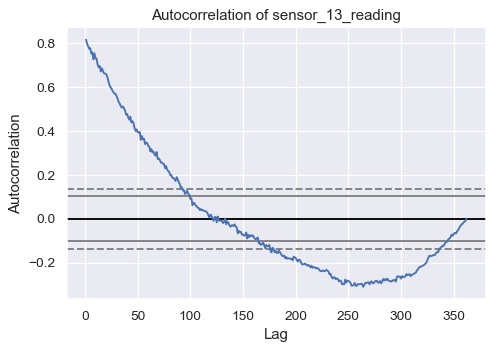

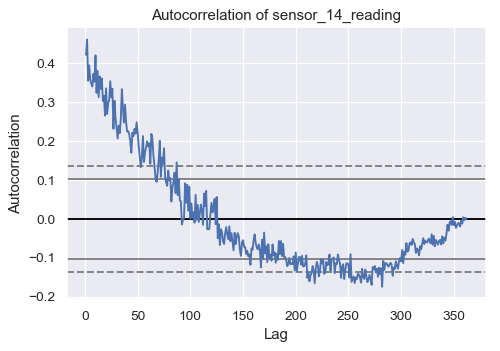

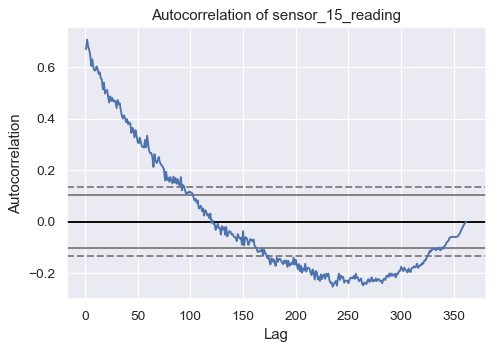

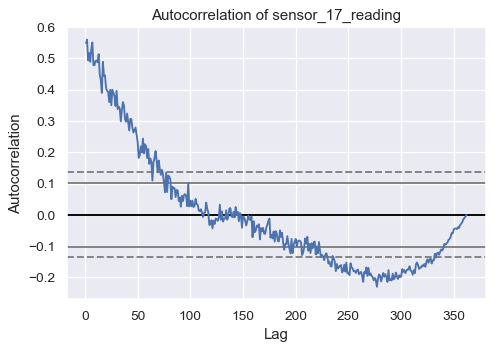

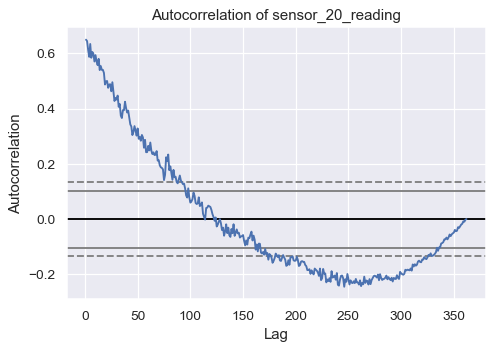

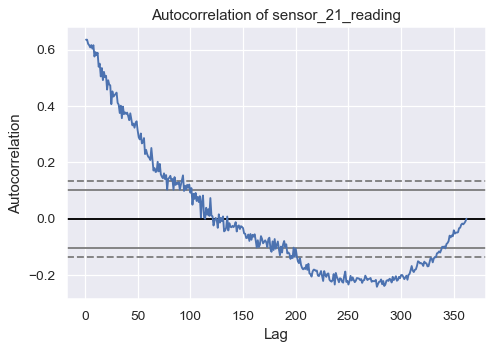

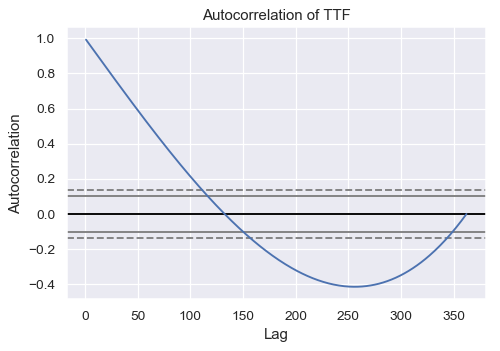

In [14]:
#plt.plot(np.correlate(train_.loc[0, 'sensor_2_reading'].values, train_.loc[0, 'sensor_2_reading'].values, 'full')[train_.loc[0, 'sensor_2_reading'].shape[0]+1:])
with sns.axes_style('dark'):
    for reading in train_.columns:
        fig, ax = plt.subplots()
        fig.figsize=(26,11.5)
        pd.plotting.autocorrelation_plot(train_.loc[unit_tmax, reading], ax=ax)
        ax.set_title("Autocorrelation of {}".format(reading))

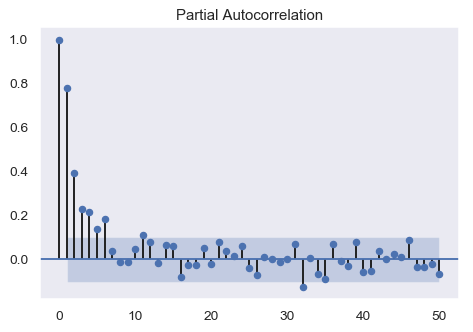

In [15]:
with sns.axes_style('dark'):
    statsmodels.graphics.tsaplots.plot_pacf(train_.loc[unit_tmax, "sensor_4_reading"], lags=50, alpha=.05)

In [16]:
np.arange(1,7).reshape(-1, 2)

array([[1, 2],
       [3, 4],
       [5, 6]])

In [17]:
lag_matrix = sm.tsa.lagmat(train_.loc[0, ('sensor_2_reading', 'sensor_3_reading')], maxlag=10, use_pandas=True)

In [18]:
sm.tools.linalg.lstsq(lag_matrix.loc[])

SyntaxError: invalid syntax (<ipython-input-18-fb87f618738a>, line 1)

In [19]:
train_ma_bh = train_.groupby(level='unit_number').rolling(7, win_type='barthann').mean()

In [20]:
train_.rolling(7, win_type='barthann').mean()

op_setting_1  op_setting_2  sensor_2_reading  \
unit_number time                                                 
0           0              nan           nan               nan   
            1              nan           nan               nan   
            2              nan           nan               nan   
            3              nan           nan               nan   
            4              nan           nan               nan   
            5              nan           nan               nan   
            6          -0.6755       -0.0503           -0.6037   
            7          -0.8191       -0.1979           -0.6181   
            8          -0.8597       -0.1150           -0.5875   
            9          -0.7430        0.2383           -0.4977   
            10         -0.6245        0.4961           -0.6012   
            11         -0.5024        0.3735           -0.8992   
            12         -0.2825        0.0906           -1.1469   
            13          0.0443        0.0508           -0.9616   
            14          0.1380        0.3303           -0.5205   
            15         -0.0069        0.4257           -0.1699   
            16         -0.1790        0.2871           -0.2153   
            17         -0.1725        0.2474           -0.4052   
            18         -0.1722        0.4439           -0.4731   
            19         -0.1851        0.3644           -0.4326   
            20         -0.2167       -0.0230           -0.4191   
            21         -0.3047       -0.2593           -0.3824   
            22         -0.4550       -0.0934           -0.1902   
            23         -0.2954        0.0020           -0.0917   
            24          0.0861       -0.0537           -0.1947   
            25          0.4776       -0.1945           -0.3621   
            26          0.4931       -0.1889           -0.3564   
            27          0.3333       -0.2650           -0.3386   
            28         -0.0130       -0.2014           -0.3950   
            29         -0.3006       -0.0378           -0.5667   
            30         -0.4506        0.2042           -0.7725   
            31         -0.3153        0.3212           -0.9600   
            32         -0.1194        0.3825           -1.0324   
            33         -0.0945        0.1553           -0.8627   
            34         -0.2589       -0.2990           -0.5198   
            35         -0.3422       -0.5819           -0.2343   
            36         -0.1962       -0.4433           -0.1324   
            37         -0.0167       -0.1548           -0.2707   
            38         -0.0797       -0.1639           -0.5773   
            39         -0.4112       -0.3115           -0.9467   
            40         -0.6628       -0.5047           -1.1671   
            41         -0.5322       -0.4990           -1.0978   
            42         -0.0156       -0.4002           -0.8777   
            43          0.3276       -0.0968           -0.7531   
            44          0.1429        0.2201           -0.8214   
            45         -0.2795        0.5143           -0.8954   
            46         -0.4217        0.5393           -0.8161   
            47         -0.2817        0.5450           -0.6239   
            48         -0.0203        0.6097           -0.6188   
            49          0.1377        0.8767           -0.8103   
            50          0.0189        0.9324           -0.8901   
            51         -0.3936        0.8029           -0.5728   
            52         -0.5963        0.5393           -0.0690   
            53         -0.2741        0.2871            0.2462   
            54          0.2605        0.1644            0.2211   
            55          0.4970        0.2996           -0.0016   
            56          0.4095        0.3825           -0.2113   
            57          0.1475        0.2076           -0.3713   
            58         -0.2211       -0.0537           -0.

In [24]:
idx = pd.IndexSlice
train_.loc[idx[:, 0:6], :]

op_setting_1  op_setting_2  sensor_2_reading  \
unit_number time                                                 
0           0          -0.3147       -1.3737           -1.6450   
            1           0.8708       -1.0329           -0.9499   
            2          -1.9561        1.0119           -0.5287   
            3           0.3236       -0.0105           -0.5287   
            4          -0.8618       -0.6921           -0.4865   
            5          -1.9561       -0.3513           -1.0552   
            6           0.4604        0.3303           -0.2549   
1           0          -0.8163        2.0343           -1.4975   
            1           1.9650       -1.0329           -1.6450   
            2           0.8252        1.0119           -2.2137   
            3           1.6003       -1.3737           -1.9398   
            4           0.2324        1.3527           -1.8345   
            5          -0.4515        1.3527           -2.7402   
            6           0.0500       -0.6921           -1.2027   
2           0           0.3692        1.6935           -1.1816   
            1          -0.4515       -0.0105            0.1243   
            2           0.5972       -0.6921           -1.1184   
            3           0.3692       -0.6921           -0.2127   
            4           0.9164        1.3527           -1.3290   
            5          -0.4515       -1.0329            0.1032   
            6          -0.8163       -1.0329            0.0400   
3           0           1.1443        1.6935           -0.0021   
            1           0.0956       -1.3737           -0.3181   
            2          -1.1354       -0.0105           -0.9289   
            3           1.0987       -1.0329            0.2717   
            4           0.5516       -0.6921           -1.0342   
            5           1.0531        1.6935           -0.2970   
            6          -0.9074        0.6711           -0.7182   
4           0           1.4179        0.6711           -1.7503   
            1           0.0956        1.0119           -0.3812   
            2           0.0956       -1.7145           -1.1184   
            3           0.7796       -1.3737           -1.0974   
            4          -0.3147        0.3303           -1.2027   
            5           0.8252        0.6711           -0.5919   
            6           0.8708        0.3303            0.3770   
5           0          -0.8618        1.0119            0.2717   
            1           0.9619       -1.3737           -1.1184   
            2          -1.4090        0.3303           -0.0653   
            3           0.2780       -0.0105           -1.3290   
            4           1.3267       -1.7145            0.0400   
            5           1.7371        0.6711           -0.5708   
            6          -0.1323        1.6935           -0.3391   
6           0          -0.2235        1.3527           -0.4655   
            1           0.3692       -1.0329           -0.0653   
            2          -0.6339       -0.6921           -0.7393   
            3          -0.9074        0.3303           -0.6129   
            4           0.7340       -0.0105           -0.7393   
            5           0.5060       -1.7145           -0.2338   
            6          -1.7282        0.6711           -0.3181   
7           0          -1.1810       -1.0329            1.2195   
            1          -0.5427       -1.0329            0.6719   
            2           0.0500        0.6711            0.2928   
            3          -0.9530        1.6935            0.3349   
            4          -2.0017        1.0119            1.1142   
            5           1.2811       -1.7145           -0.1074   
            6          -1.0898        1.3527            0.5455   
8           0           0.2324        1.3527           -0.8867   
            1           0.0500        0.3303           -1.4554   
            2          -0.4059       -1.0329           -0.

In [66]:
train_.index.levels[0][:6]

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64', name='unit_number')

In [50]:
train_.loc[1].rolling(7, win_type='barthann', level='unit_number').mean()

TypeError: rolling() got an unexpected keyword argument 'level'

In [ ]:
pd.DataFrame()